In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, NVPFlow, LogNormal, GVAR, phase,Normal, floatX, MVNormal, MVNormalRW, Linear, LinearChol
from flows.models import VARmodel
import flows

import numpy as np
import pandas as pd
from tensorflow.contrib.distributions import WishartCholesky
import math
from tqdm import tqdm
import pickle as pkl

np.random.seed(1234)
tf.set_random_seed(1234)

ccodes = ['AUS', 'FRA', 'GBR']
datas = ['../../CDATA/{}.csv'.format(x) for x in ccodes]

datas = [pd.read_csv(x, index_col='VARIABLE').iloc[:,:-1] for x in datas]

mean_std = 0.
for data in datas:
    std = np.std(data.values[:,1:] - data.values[:,:-1], axis=1)
    mean_std = std + mean_std
mean_std /= len(datas)
mean_std = np.concatenate([mean_std]*2, axis=0)
print('Mean std: {}'.format(mean_std))

max_year = 0
for i, data in enumerate(datas):
    data = data.astype(floatX)
    data.columns = data.columns.astype('float32')
    
    new_data = np.concatenate([data.values.T[1:], data.values.T[:-1]], axis=1)
    new_data_columns = data.columns[1:]
    new_data = pd.DataFrame(new_data.T/mean_std[:,np.newaxis], columns=new_data_columns)
    data = new_data
    datas[i] = data
    max_year = max(max(data.columns), max_year)

VAR_DIM = 4

YEARS = [x for x in data.columns if x > 2000]

country_data = {c:d for c,d in zip(ccodes, datas)}

NUM_SAMPLES=1024

#BUILDING the model

current_year = tf.placeholder(tf.float32, shape=(), name='current_year')
tf.summary.scalar('current_year', current_year)

with tf.variable_scope('variation_rate', dtype=floatX):
    variation_prior = tf.distributions.Exponential(rate=.3)
    dim_ = (VAR_DIM*2+1)*VAR_DIM
    variation_mu = tf.get_variable('mu', shape=[dim_], initializer=tf.constant_initializer(math.log(0.3)))
    variation_presigma = tf.get_variable('presigma', shape=[dim_], initializer=tf.constant_initializer(-3.))
    variation_d = LogNormal(shape=[NUM_SAMPLES, dim_], mu=variation_mu[tf.newaxis], 
                            sigma=tf.exp(variation_presigma)[tf.newaxis])
    
    variation = variation_d.sample()

    pp = tf.cast(tf.reduce_sum(variation_prior.log_prob(tf.cast(variation, tf.float32)), axis=-1), floatX)
    ld = tf.reduce_sum(variation_d.logdens(variation, reduce=False), axis=-1)
    tf.add_to_collection('logdensities', ld)
    tf.add_to_collection('priors', pp)

    tf.summary.histogram('variation', variation)
    tf.summary.scalar('mean_variation', tf.reduce_mean(variation))

global_inf = DFlow([NVPFlow(dim=(VAR_DIM*2+1)*VAR_DIM, name='flow_{}'.format(i), aux_vars=variation) for i in range(6)], 
                    init_sigma=0.01, num_samples=NUM_SAMPLES)

pmat = np.ones([VAR_DIM, VAR_DIM*2+1], dtype=floatX)
pmat[:,:VAR_DIM] = 0.1
pmat[:,VAR_DIM:2*VAR_DIM] = 1.
pmat[:,-1] = 1.

global_sigma = tf.constant(pmat.reshape(-1), dtype=floatX)[tf.newaxis]
global_prior = Normal(None, sigma=global_sigma).logdens(global_inf.output, reduce=False)
global_prior = tf.reduce_sum(global_prior, axis=-1)
tf.add_to_collection('priors', global_prior)
tf.add_to_collection('logdensities', global_inf.logdens)

individ_variation_prior = Normal(dim=None, sigma=variation, mu=global_inf.output)

models = []
indivs = {}

with tf.variable_scope(tf.get_variable_scope(), dtype=floatX, reuse=tf.AUTO_REUSE):
    for country, data in country_data.items():
        with tf.variable_scope(country):
            aux = tf.concat([global_inf.output, variation], axis=-1)
            individ_variation = DFlow([NVPFlow((VAR_DIM*2+1)*VAR_DIM, 
                                               name='nvp_{}'.format(i), 
                                               aux_vars=aux) for i in range(6)], init_sigma=0.01, num_samples=NUM_SAMPLES)

            ind = individ_variation.output + global_inf.output
            indivs[country] = ind

            tf.add_to_collection('logdensities', individ_variation.logdens)
            tf.add_to_collection('priors', tf.reduce_sum(individ_variation_prior.logdens(ind, reduce=False), axis=-1))

        model = VARmodel(data, name='{}_model'.format(country), var_dim=VAR_DIM, mu=ind, current_year=current_year, num_samples=NUM_SAMPLES)
        models.append(model)

graph = tf.get_default_graph()

fp = tf.reduce_sum([model.priors for model in models], axis=[0,1])
sp = tf.reduce_sum(graph.get_collection('priors'), axis=0)
prior = fp + sp

logdensity = tf.reduce_sum([model.logdensities for model in models], axis=[0,1]) + tf.add_n(graph.get_collection('logdensities'))

kl = logdensity - prior
print(kl)
kl = tf.reduce_mean(kl)
kl /= 36*200*4


kls = tf.summary.scalar('KLd', kl)
summary = tf.summary.merge_all()

saver = tf.train.Saver()
with tf.variable_scope('build_upd') as upd_scope:
    vs = tf.global_variables()
    grads = tf.gradients(kl, vs)
    upd = zip(grads, vs)
    gnans = [tf.check_numerics(x, 'nan in {}'.format(x.op.name)) for x in grads]
    with tf.control_dependencies(gnans):
        main_op = tf.train.AdamOptimizer(0.002).apply_gradients(upd)

#graph = tf.get_default_graph()
#upd_vars = graph.get_collection('variables', scope=upd_scope)

sess = tf.InteractiveSession()
from flows.debug import wrapper
#sess = wrapper(sess)
#init = [tf.global_variables_initializer(), tf.variables_initializer(upd_vars)]
init = tf.global_variables_initializer()

sess.run(init)

writer = tf.summary.FileWriter('/tmp/tfdbg/gvar_cond4_cont_corrected')

def validate_year(year):
    cdic = {model.name:model for model in models}
    preds = {model.name:[] for model in models}
    preds_t = {model.name: model.preds for model in models}

    for step in range(3):
        preds_i = sess.run(preds_t, {current_year:year})
        preds_i = {k:v.mean(axis=1) for k,v in preds_i.items()}
        for k in preds.keys():
            preds[k].append(preds_i[k][cdic[k].years > year])
            
    mean_pred = {k:np.mean(v, axis=0) for k,v in preds.items()}
    for c, pred in mean_pred.items():
        pred_years = [x for x in YEARS if x > year]
        pred = pd.DataFrame(pred.T, columns=pred_years)
        mean_pred[c] = pred

    for model in models:
        try:
            a = model.data_raw.loc[:,year].values[:VAR_DIM]
        except KeyError:
            a = np.zeros(VAR_DIM, dtype=floatX)*np.nan
        mean_pred[model.name]['CYEAR={}'.format(year)] = a
    return mean_pred

saver.restore(sess, '../shrinkage_cond-MP-multisample/save/gvar_hier_fullcond1000-MP')

Instructions for updating:
Use the retry module or similar alternatives.
Mean std: [0.00997741 1.20220203 0.00878533 0.04104758 0.00997741 1.20220203
 0.00878533 0.04104758]
ldiag logdens Tensor("AUS_model/rw_priors/PWalk_inf/flows/sub_1:0", shape=(1024,), dtype=float32)
pwld Tensor("AUS_model/PWald_prior/OrdWalk/logdens/concat:0", shape=(1024, 201), dtype=float32)
Prior disp: [0.67596424 0.7066679  0.61292326 0.8164308 ]
preds Tensor("AUS_model/strided_slice:0", shape=(201, 1024, 4), dtype=float32)
blogl Tensor("AUS_model/loglikelihood/mul:0", shape=(200, 1024), dtype=float32)
logl Tensor("AUS_model/loglikelihood/Sum_1:0", shape=(1024,), dtype=float32)
ldiag logdens Tensor("FRA_model/rw_priors/PWalk_inf/flows/sub_1:0", shape=(1024,), dtype=float32)
pwld Tensor("FRA_model/PWald_prior/OrdWalk/logdens/concat:0", shape=(1024, 193), dtype=float32)
Prior disp: [0.286496   0.38744742 0.28630462 0.36744264]
preds Tensor("FRA_model/strided_slice:0", shape=(193, 1024, 4), dtype=float32)
blogl T

In [2]:
ced = tf.stack([indivs['AUS'], global_inf.output], axis=0)

In [3]:
ced

<tf.Tensor 'stack:0' shape=(2, 1024, 36) dtype=float32>

In [4]:
x = ced.eval()

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

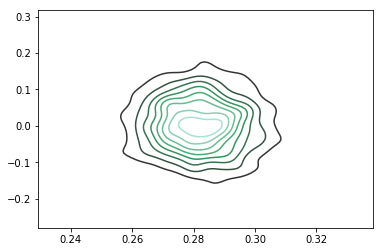

In [12]:
i = 3
sns.kdeplot(x[0,:,i], x[1,:,i])
plt.show()

In [10]:
np.mean(x[0], axis=0)

array([ 3.57949026e-02, -5.37119526e-03, -9.67160857e-04,  2.81867653e-01,
       -7.73592144e-02,  3.17367077e-01, -1.61387138e-02, -1.31384030e-01,
        2.17815284e-02,  2.49058217e-01, -6.14508927e-01,  1.06192499e-01,
       -1.16145223e-01, -4.66810120e-03, -1.64970326e+00,  1.54061364e-02,
       -8.75951469e-01, -1.98326074e-02,  7.81551749e-02,  8.78148302e-02,
        3.00762095e-02,  2.66057134e-01,  2.47089732e-02,  1.67439088e-01,
       -1.92615017e-01, -1.85839221e-01,  2.47151740e-02, -5.61122477e-01,
        4.92065549e-01,  8.89935374e-01,  1.20212056e-01, -1.97982073e-01,
        3.81326564e-02, -1.34253763e-02, -3.40375900e-01,  2.30976921e-02],
      dtype=float32)

In [11]:
np.std(x[0], axis=0)

array([0.01986072, 0.0149078 , 0.01692536, 0.01151797, 0.03908845,
       0.01821125, 0.03998533, 0.0150099 , 0.01443463, 0.01358327,
       0.0125126 , 0.01605324, 0.01000496, 0.07536656, 0.015585  ,
       0.08175133, 0.0154654 , 0.01414653, 0.0126323 , 0.01180744,
       0.01362043, 0.01032354, 0.02678472, 0.01567221, 0.02615193,
       0.0142639 , 0.0146503 , 0.01553839, 0.01294235, 0.01992571,
       0.01103715, 0.05816751, 0.01753474, 0.07048482, 0.01784244,
       0.01574476], dtype=float32)